# Traffic Light Detection and Classification

## Table of contents
- [Data Source](#ds)
   - [Process Udacity Camera Feed](#Process)
- [Traffic Light Detection](#Detection)
- [Traffic Light Detection and Classification](#Classification)
   - [1. select the model](#select)
   - [2. generate the training and validation sets](#generate)
   - [3. update the model configuration](#update)
   - [4. retrain the model](#retrain)
   - [5. freeze the best model](#freeze) 
- [Testing on videos](#video)
   - [Image to Video](#image2video) 
   - [Video Pipeline](#pipeline) 


<a id='ds'></a>
## Data Source
[[ go back to the top ]](#Table-of-contents)

* Udacity Camera Feed (3.49 GB compressed files)

These images became available on August 24th over the slack channel #p-system-integration. It contains two bag files with an image feed from the Udacity self-driving car's camera in the test lot and a topic containing the car's position at [google drive](https://drive.google.com/file/d/0B2_h37bMVw3iYkdJTlRSUlJIamM/view?usp=sharing).

* Udacity simulator images

In [12]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import hashlib
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageColor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 6)

<a id='Process'></a>
### Process Udacity Camera Feed
[[ go back to the top ]](#Table-of-contents)

Using the command line below to extract color images from bag files and save all files in a folder, the python script can be downloaded [here]():

`python script/bag_to_images.py just_traffic_light.bag just_traffic_light/`

`python script/bag_to_images.py loop_with_traffic_light.bag loop_with_traffic_light/`

In [4]:
bag1 = 'just_traffic_light'
bag2 = 'loop_with_traffic_light'

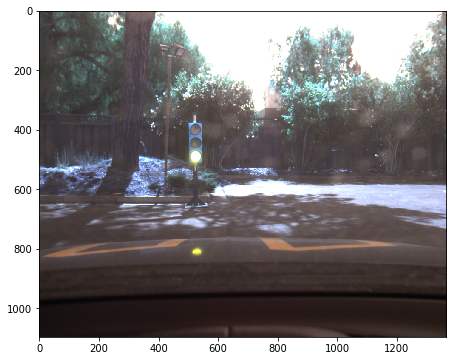

In [3]:
udacity_train = bag1 + '/frame000300.png'
image = Image.open(udacity_train)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)

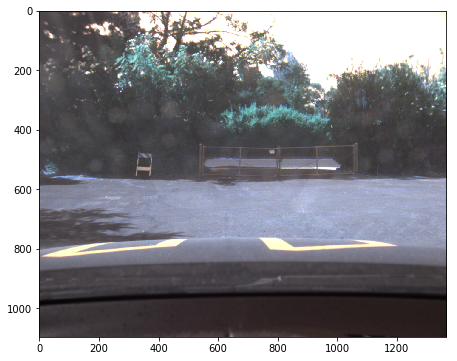

In [4]:
udacity_train = bag2 + '/frame000000.png'
image = Image.open(udacity_train)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image)

In [30]:
bag1 = 'just_traffic_light'
bag2 = 'loop_with_traffic_light'
test_images = [os.path.join(bag1,'frame00030{}.png'.format(i)) for i in range(1) ]

<a id='Detection'></a>
## Traffic Light Detection
[[ go back to the top ]](#Table-of-contents)

 There are a few models can be downloaded from the [TensorFlow detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). In this project, we used a Faster RCNN model, which can be downloaded from [here]( http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz) (746.4 MB). Label maps map indices to category names, so that when our convolution network predicts 10, we know that this corresponds to traffic lights. Label maps can be downloaded [here](https://github.com/tensorflow/models/tree/master/research/object_detection/data). Files in the `faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28` folder are shown below.

Also, We downloaded all files in folder [object_detection](https://github.com/tensorflow/models/tree/master/research/object_detection) and only kept all the needed files for our purposes. Two files - `label_map_util.py`, `visualization_utils.py` - will be used in this section and more files will be used in the next section. 

In [19]:
from utils import visualization_utils as vis_util
from utils import label_map_util

In [12]:
FASTER_RCNN = 'model/faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/'
FASTER_RCNN_GRAPH_FILE = FASTER_RCNN + 'frozen_inference_graph.pb'
PATH_TO_LABELS = FASTER_RCNN + 'mscoco_label_map.pbtxt'  # we put it in the same directory as the model directory
NUM_CLASSES = 90 

In [13]:
for file in os.listdir(FASTER_RCNN):
    print(file)

frozen_inference_graph.pb
.DS_Store
.ipynb_checkpoints
model.ckpt.data-00000-of-00001
saved_model
pipeline.config
model.ckpt.index
checkpoint
mscoco_label_map.pbtxt
model.ckpt.meta


Now we want to load the graph and do traffic light detection on our data.

In [14]:
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

In [15]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

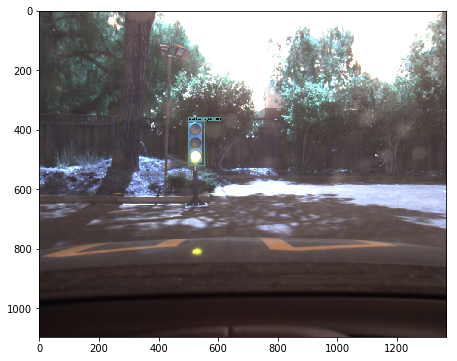

In [19]:
detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES, 
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in test_images:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=4)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

This pretrained model can detect traffic lights well in the image, one example detection is shown above.

<a id='Classification'></a>
## Traffic Light Detection and Classification
[[ go back to the top ]](#Table-of-contents)

We followed the installation instruction [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) to install necessary packages. Also, [this post on Medium](https://becominghuman.ai/tensorflow-object-detection-api-tutorial-training-and-evaluating-custom-object-detector-ed2594afcf73) is helpful for us to use Tensorflow Object Detection API to train our own model. We encoutered two issues during the installation and using the API and the solutions are shown below:

** 1. use protoc-3.2.0 rather than 2.6.1 **, use the command line below to uninstall protoc-2.6.1 and install protoc-3.2.0

sudo apt-get remove protobuf-compiler

curl -OL https://github.com/google/protobuf/releases/download/v3.2.0/protoc-3.2.0-linux-x86_64.zip

unzip protoc-3.2.0-linux-x86_64.zip -d protoc3

sudo mv protoc3/bin/* /usr/local/bin/

sudo mv protoc3/include/* /usr/local/include/

** 2. Python3 incompatibility issue **, need to modify models/research/object_detection/utils/learning_schedules.py lines 167-169. Currently it is

`rate_index = tf.reduce_max(tf.where(tf.greater_equal(global_step, boundaries),
                                      range(num_boundaries),
                                      [0] * num_boundaries))`
                                      
Wrap list() around the range() like this:

`rate_index = tf.reduce_max(tf.where(tf.greater_equal(global_step, boundaries),
                                     list(range(num_boundaries)),
                                      [0] * num_boundaries))`

The detailed steps of using the API is shown below.

<a id='select'></a>
### 1. select the model
[[ go back to the top ]](#Table-of-contents)

In this project, we selected the same Faster RCNN model.

<a id='generate'></a>
### 2. generate the training and validation sets
[[ go back to the top ]](#Table-of-contents)

We followed the API instruction on how to create the dataset for the API here and used the pretrained model and weights in a script to help generate the training and validation sets. We use [two pre-generated and hand labeled CSV file]() to generate our training and validation set.

`python script/generate_data_sets.py --infilename data/just_traffic_light.csv --outfilename data/mscoco_train.record`

`python script/generate_data_sets.py --infilename data/loop_with_traffic_light.csv --outfilename data/mscoco_val.record`


<a id='update'></a>
### 3. update the model configuration
[[ go back to the top ]](#Table-of-contents)


We changed the model configuaration from 300 to 4 max predictions and the number of labels from 900 to 4 to reduce the prediction time. The modified version can be downloaded [here](). 

`num_classes: 4
first_stage_max_proposals: 4
maxpool_kernel_size: 2
maxpool_stride: 2
second_stage_batch_size: 4
second_stage_post_processing
    max_detections_per_class: 3
    max_total_detections: 4
num_steps: 10000`

** remove the code below in the config file **

`schedule {
step: 0
learning_rate: 0.000300000014249
}`



<a id='retrain'></a>
### 4. retrain the model 
[[ go back to the top ]](#Table-of-contents)


copy data/, directories to object-detection/ directory. Create a new folder training/ and copy the config file to this directory. Our folder structure is as follows:

* data/ — has records and csv files.
* images/ — This directory contains our dataset.
* training/ — In this directory we save our trained model.



Note this `train.py` script is from [object_detection folder](https://github.com/tensorflow/models/tree/master/research/object_detection). Next, we start to train the model:
    
`python train.py --logtostderr --train_dir=training/ --pipeline_config=training/pipeline_modified.config`

<a id='freeze'></a>
###  5. freeze the best model
[[ go back to the top ]](#Table-of-contents)

After the training is complete, freeze the best model using the highest checkpoint number (assuming 10000 for this example). Note this `export_inference_graph.py` script is also from [object_detection folder](https://github.com/tensorflow/models/tree/master/research/object_detection):

`ls training/model.ckpt*`

`python export_inference_graph.py --input_type image_tensor --pipeline_config_path training/pipeline_modified.config --trained_checkpoint_prefix training/model.ckpt-10000 --output_directory final/`

In [9]:
PATH_TO_LABELS = 'research/object_detection/data/sdc_label_map.pbtxt' 
GRAPH_FILE = 'research/object_detection/final/frozen_inference_graph.pb'
NUM_CLASSES = 4

In [20]:
detection_graph = load_graph(GRAPH_FILE)
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES, 
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

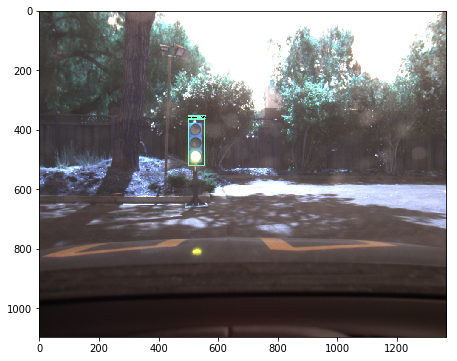

In [14]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in test_images:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=4)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

This trained model is able to locate the traffic light in a image and classify its color.

<a id='video'></a>
## Testing on videos
[[ go back to the top ]](#Table-of-contents)


In [1]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip, ImageSequenceClip
from IPython.display import HTML
import glob

<a id='image2video'></a>
### Image to Video
[[ go back to the top ]](#Table-of-contents)

We first conbine all images into a video, and we have two videos: just_traffic_light.mp4 and loop_with_traffic_light.mp4 after running the code below.

In [2]:
def image_to_video(images_folder):
    # list of image paths
    myfiles = glob.glob(images_folder+"/*.png")
    myfiles.sort()
    # combine images to a video
    foutput = 'video/' + images_folder + '.mp4'
    clip = ImageSequenceClip(myfiles, load_images=True, fps=25)
    # output a video
    clip.write_videofile(foutput)

In [6]:
image_to_video(bag1)
image_to_video(bag2)

[MoviePy] >>>> Building video video/just_traffic_light.mp4
[MoviePy] Writing video video/just_traffic_light.mp4


100%|██████████| 712/712 [00:07<00:00, 95.25it/s] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/just_traffic_light.mp4 

[MoviePy] >>>> Building video video/loop_with_traffic_light.mp4
[MoviePy] Writing video video/loop_with_traffic_light.mp4


100%|██████████| 1151/1151 [00:15<00:00, 72.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/loop_with_traffic_light.mp4 



<a id='pipeline'></a>
### Video Pipeline
[[ go back to the top ]](#Table-of-contents)

We created the pipeline below to detect and classify traffic light in videos, the results are promising.

In [7]:
finput1 = 'video/' + bag1 + '.mp4'
foutput1 = 'video/' + bag1 + '_detection.mp4'

finput2 = 'video/' + bag2 + '.mp4'
foutput2 = 'video/' + bag2 + '_detection.mp4'

In [8]:
def pipeline(img):
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    draw_img = img
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    # Actual detection.
    (boxes, scores, classes, num) = sess.run([detection_boxes, 
                                              detection_scores, 
                                              detection_classes, 
                                              num_detections],
                                             feed_dict={image_tensor: np.expand_dims(img, 0)})
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(draw_img,np.squeeze(boxes),
                                                       np.squeeze(classes).astype(np.int32),
                                                       np.squeeze(scores),
                                                       category_index,
                                                       use_normalized_coordinates=True,
                                                       line_thickness=8)
    return draw_img

In [21]:
with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    clip = VideoFileClip(finput1)
    print("video size: ", clip.size)
    new_clip = clip.fl_image(pipeline)
    %time new_clip.write_videofile(foutput1, audio=False)

video size:  [1368, 1096]
[MoviePy] >>>> Building video video/just_traffic_light_detection.mp4
[MoviePy] Writing video video/just_traffic_light_detection.mp4


100%|█████████▉| 712/713 [00:40<00:00, 17.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/just_traffic_light_detection.mp4 

CPU times: user 51 s, sys: 17.1 s, total: 1min 8s
Wall time: 41.2 s


In [25]:
HTML("""
<video width="700" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('video/just_traffic_light_detection.mp4'))

In [23]:
with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    clip = VideoFileClip(finput2)
    print("video size: ", clip.size)
    new_clip = clip.fl_image(pipeline)
    %time new_clip.write_videofile(foutput2, audio=False)

video size:  [1368, 1096]
[MoviePy] >>>> Building video video/loop_with_traffic_light_detection.mp4
[MoviePy] Writing video video/loop_with_traffic_light_detection.mp4


100%|█████████▉| 1151/1152 [01:02<00:00, 18.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/loop_with_traffic_light_detection.mp4 

CPU times: user 1min 17s, sys: 25.4 s, total: 1min 43s
Wall time: 1min 2s


In [26]:
HTML("""
<video width="700" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('video/loop_with_traffic_light_detection.mp4'))